In [2]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

import numpy as np
import h5py
import nbodykit
from nbodykit.lab import BigFileCatalog, HaloCatalog, cosmology, FFTPower, SimulationBox2PCF
import matplotlib.pyplot as plt


# Implement HOD

## `Nbodykit` interface:

### Default Zheng+07:

In [2]:
cosmo = cosmology.Planck15
from nbodykit.hod import Zheng07Model


def load_hlo_cat():
    pig_file = '/home/qezlou/HD1/simulations/Goku/PIG_016'
    cat = BigFileCatalog(pig_file, dataset='FOFGroups')
    redshift = 1/cat.attrs['Time'] - 1
    cat['Mass'] *= 1e10
    halos = HaloCatalog(cat, 
                        cosmo=cosmo, 
                        redshift=redshift,
                        mdef='vir',
                        mass='Mass',
                        position='MassCenterPosition',
                        velocity='MassCenterVelocity')
    halos.attrs['BoxSize'] /= 1000
    halos['Position'] /= 1000
    print(redshift)
    return halos

def populate_halos(hod_model=Zheng07Model, model_params={}, seed=42):
    halos = load_hlo_cat()
    hod = halos.populate(hod_model, seed=seed, **model_params)
    print("total number of HOD galaxies = ", hod.csize)
    print(hod.columns)

    print("number of centrals = ", hod.compute((hod['gal_type']==0).sum()))
    print("number of satellites = ", hod.compute((hod['gal_type']==1).sum()))


    cen_idx = hod['gal_type'] == 0
    sat_idx = hod['gal_type'] == 1

    cens = hod[cen_idx]
    sats = hod[sat_idx]

    return hod, cens, sats


def plot_power(fig, ax, seed=42, hod_model=Zheng07Model, model_params={}):
    """Plot the power spectrum of the galaxies, centrals, and satellites."""
    hod, cens, sats = populate_halos(hod_model=hod_model, 
                                     model_params=model_params, 
                                     seed=seed)
    gal_power = FFTPower(hod, mode='1d', Nmesh=512)
    cen_power = FFTPower(cens, mode='1d', Nmesh=512)
    sat_power = FFTPower(sats, mode='1d', Nmesh=512)
    cen_sat_power = FFTPower(cens, second=sats, mode='1d', Nmesh=512)
    # z-space pwoer
    LOS = [0, 0, 1]
    hod['RSDPosition'] = hod['Position'] + hod['VelocityOffset'] * LOS
    mesh = hod.to_mesh(position='RSDPosition', Nmesh=512, compensated=True)
    rsd_gal_power = FFTPower(mesh, mode='1d').run()[0]


    # plot galaxy auto power, centrals auto power, and sats auto power
    labels = [r"$P^{gg}$"+ f' {hod_model.__name__}', 
              r"$P^{cc}$"+ f' {hod_model.__name__}', 
              r"$P^{ss}$"+ f' {hod_model.__name__}']
    for i, r in enumerate([gal_power, cen_power, sat_power]):
        Pk = r.power
        ax.loglog(Pk['k'], Pk['power'].real-Pk.attrs['shotnoise'], label=labels[i])

    ax.loglog(rsd_gal_power['k'], rsd_gal_power['power']-rsd_gal_power.attrs['shotnoise'], 
              label=r'$P^{gg}_{zspace}$'+ f' {hod_model.__name__}', ls='--')
    ax.legend()
    ax.set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
    ax.set_ylabel(r"$P(k)$ [$h^{-3} \ \mathrm{Mpc}^3$]")


def plot_corr(fig, ax, seed=42):
    """Plot the power spectrum of the galaxies, centrals, and satellites."""
    hod, cens, sats = populate_halos(seed=seed)
    r_edges = np.arange(60,200,5)
    corr_gal_real = SimulationBox2PCF(data1=hod, mode='1d', edges=r_edges, position='Position', nthreads=12)
    corr_gal_real.run()

    # z-space pwoer
    LOS = [0, 0, 1]
    hod['RSDPosition'] = hod['Position'] + hod['VelocityOffset'] * LOS
    corr_gal_zspace = SimulationBox2PCF(data1=hod, mode='1d', edges=r_edges,  position='RSDPosition', nthreads=12)
    corr_gal_zspace.run()
    
    ax.plot(corr_gal_real.corr['r'], corr_gal_real.corr['corr'], label=r'$\xi^{gg}_{zspace}$', ls='--')
    ax.plot(corr_gal_zspace.corr['r'], corr_gal_zspace.corr['corr'], label=r'$\xi^{gg}_{zspace}$', ls='--')
    print(corr_gal_real.corr['r'], corr_gal_real.corr['corr'])
    ax.set_xlabel(r"$r$ [$h^{-1} \ \mathrm{Mpc}$]")
    ax.set_ylabel(r"$\xi(r)$")


def get_corr(seed=42):
    """Plot the power spectrum of the galaxies, centrals, and satellites."""
    hod, cens, sats = populate_halos(seed=seed)
    r_edges = np.arange(1,200,1)
    corr_gal_real = SimulationBox2PCF(data1=hod, mode='1d', edges=r_edges, position='Position')
    corr_gal_real.run()
    

    # z-space corr function
    LOS = [0, 0, 1]
    hod['RSDPosition'] = hod['Position'] + hod['VelocityOffset'] * LOS
    corr_gal_zspace = SimulationBox2PCF(data1=hod, mode='1d', edges=r_edges,  position='RSDPosition')
    corr_gal_zspace.run()

    cen_idx = hod['gal_type'] == 0
    sat_idx = hod['gal_type'] == 1
    cens = hod[cen_idx]
    sats = hod[sat_idx]

    corr_cen_zspace = SimulationBox2PCF(data1=cens, mode='1d', edges=r_edges, position='RSDPosition')
    corr_cen_zspace.run()

    corr_sat_zspace = SimulationBox2PCF(data1=sats, mode='1d', edges=r_edges, position='RSDPosition')
    corr_sat_zspace.run()


    if rank == 0:
        with h5py.File('halo_corr.hdf5', 'w') as f:
            f['r'] = corr_gal_real.corr['r']
            f['corr/real'] = corr_gal_real.corr['corr']
            f['corr/zspace'] = corr_gal_zspace.corr['corr']
            f['corr/cen_zspace'] = corr_cen_zspace.corr['corr']
            f['corr/sat_zspace'] = corr_sat_zspace.corr['corr']
    comm.Barrier()




total number of HOD galaxies =  289236
['Position', 'Selection', 'Value', 'Velocity', 'VelocityOffset', 'Weight', 'conc_NFWmodel', 'gal_type', 'halo_hostid', 'halo_id', 'halo_mvir', 'halo_num_centrals', 'halo_num_satellites', 'halo_rvir', 'halo_upid', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_x', 'halo_y', 'halo_z', 'host_centric_distance', 'vx', 'vy', 'vz', 'x', 'y', 'z']
number of centrals =  244921
number of satellites =  44315
[ 62.56373061  67.56004275  72.5558565   77.55313263  82.55033197
  87.54801057  92.54358055  97.54233924 102.53967328 107.53811596
 112.53666944 117.53476965 122.53348499 127.53306354 132.53119378
 137.53050602 142.52889773 147.52855799 152.52740486 157.52635019
 162.52574953 167.52471544 172.52411063 177.52334092 182.52231916
 187.522128   192.52184966] [ 2.64276476e-02  2.04507704e-02  1.57137017e-02  1.31334068e-02
  1.33539942e-02  1.32282266e-02  1.25399816e-02  1.21195935e-02
  1.00054404e-02  7.63625889e-03  5.56333326e-03  4.52560628e-03
  2.65059472e-0

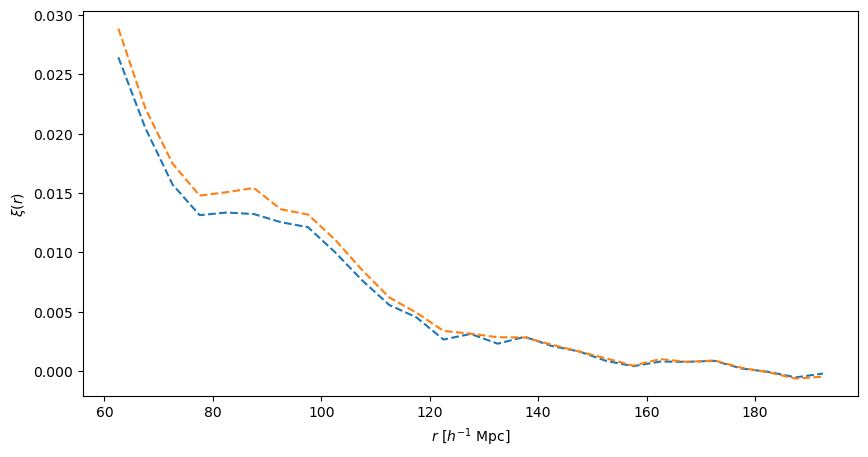

In [19]:
fig ,ax = plt.subplots(1, 1, figsize=(10, 5))
plot_corr(fig, ax)


<KeysViewHDF5 ['corr', 'r']>
[1.25907532e-01 4.49098150e-01 6.17804248e-01 8.04837675e-01
 9.50716459e-01 1.50670194e+00 2.50804502e+00 3.50814139e+00
 4.50866043e+00 5.50966751e+00 6.50988131e+00 7.50915540e+00
 8.50782232e+00 9.50867352e+00 1.05091792e+01 1.15066677e+01
 1.25084394e+01 1.35071592e+01 1.45076112e+01 1.55063479e+01
 1.65070115e+01 1.75057415e+01 1.85070634e+01 1.95070279e+01
 2.05069365e+01 2.15065218e+01 2.25063055e+01 2.35060020e+01
 2.45051155e+01 2.55055051e+01 2.65055086e+01 2.75048130e+01
 2.85046470e+01 2.95041581e+01 3.26140823e+01 3.76008026e+01
 4.25916717e+01 4.75808561e+01 5.25750381e+01 5.75684220e+01
 6.25645397e+01 6.75592485e+01 7.25562610e+01 7.75535674e+01
 8.25501412e+01 8.75473955e+01 9.25443281e+01 9.75419934e+01
 1.02539185e+02 1.07537684e+02 1.12536794e+02 1.17535477e+02
 1.22533133e+02 1.27532541e+02 1.32531308e+02 1.37529901e+02
 1.42528841e+02 1.47528194e+02 1.52527319e+02 1.57526422e+02
 1.62525742e+02 1.67524885e+02 1.72524314e+02 1.77523323

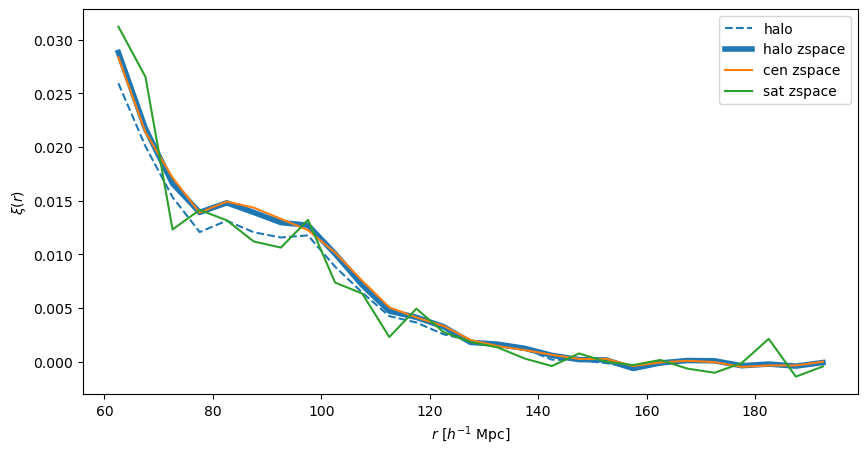

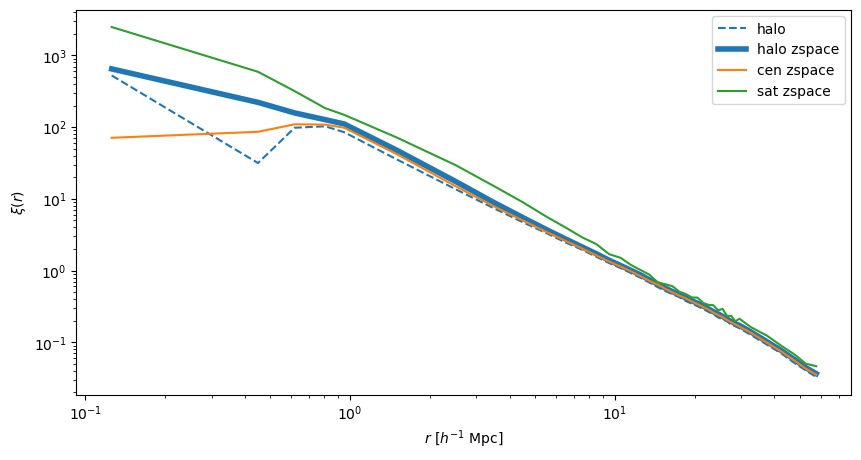

In [16]:
with h5py.File('./data/halo_corr.hdf5','r') as f:
    print(f.keys())
    r = f['r'][:]
    print(r)
    xi_real = f['corr/real'][:]
    xi_zspace = f['corr/zspace'][:]
    xi_cen = f['corr/cen_zspace'][:]
    xi_sat = f['corr/sat_zspace'][:]
    ind_bins = [r > 60, r < 60]
    for ind in ind_bins:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))    
        ax.plot(r[ind], xi_real[ind], label='halo', ls='--',color='C0')
        ax.plot(r[ind], xi_zspace[ind], label='halo zspace', color='C0', lw=4)
        ax.plot(r[ind], xi_cen[ind], label='cen zspace', color='C1')
        ax.plot(r[ind], xi_sat[ind], label='sat zspace', color='C2')
        ax.legend()
        ax.set_ylabel(r"$\xi(r)$")
        ax.set_xlabel(r"$r$ [$h^{-1} \ \mathrm{Mpc}$]")
    ax.set_xscale('log')
    ax.set_yscale('log')

<KeysViewHDF5 ['corr', 'r']>
[1.24606008e-01 4.48078845e-01 6.16898663e-01 8.04906451e-01
 9.49929653e-01 1.50754364e+00 2.50952653e+00 3.51121260e+00
 4.50840885e+00 5.51002856e+00 6.51005356e+00 7.51078112e+00
 8.50910289e+00 9.50888603e+00 1.05084918e+01 1.15066975e+01
 1.25075187e+01 1.35071767e+01 1.45075679e+01 1.55077248e+01
 1.65077424e+01 1.75064345e+01 1.85072361e+01 1.95073615e+01
 2.05057549e+01 2.15071076e+01 2.25063918e+01 2.35060039e+01
 2.45051543e+01 2.55058524e+01 2.65055421e+01 2.75048413e+01
 2.85050132e+01 2.95046372e+01 3.26129325e+01 3.76027369e+01
 4.25906750e+01 4.75805631e+01 5.25772884e+01 5.75689710e+01
 6.25653720e+01 6.75608846e+01 7.25548552e+01 7.75535762e+01
 8.25507059e+01 8.75472109e+01 9.25442394e+01 9.75424150e+01
 1.02539571e+02 1.07537945e+02 1.12537236e+02 1.17535214e+02
 1.22533833e+02 1.27532706e+02 1.32530763e+02 1.37530372e+02
 1.42529148e+02 1.47528290e+02 1.52526604e+02 1.57526399e+02
 1.62525816e+02 1.67525041e+02 1.72524087e+02 1.77523296

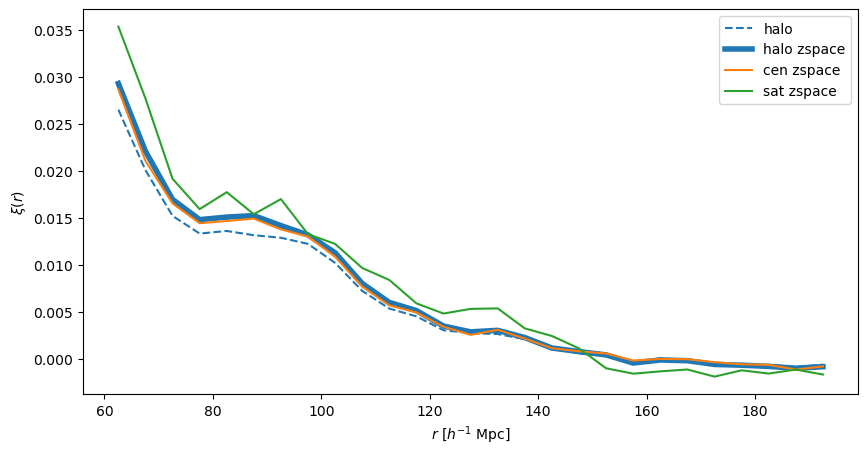

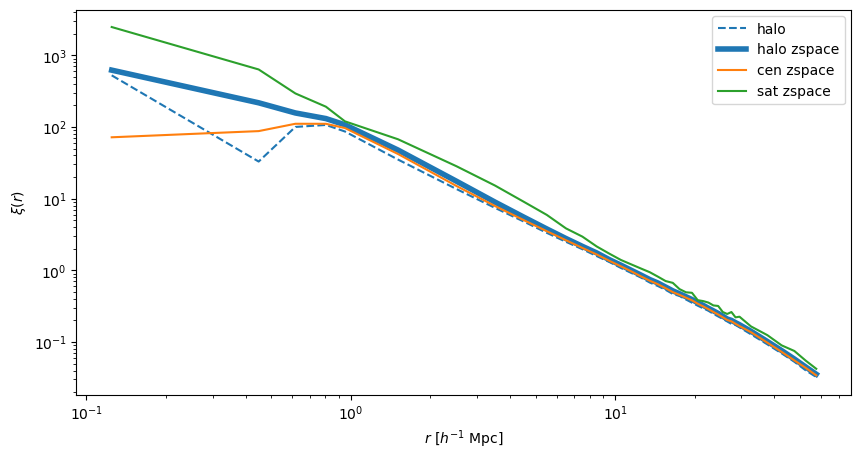

In [17]:
with h5py.File('./data/halo_corr_seed123.hdf5','r') as f:
    print(f.keys())
    r = f['r'][:]
    print(r)
    xi_real = f['corr/real'][:]
    xi_zspace = f['corr/zspace'][:]
    xi_cen = f['corr/cen_zspace'][:]
    xi_sat = f['corr/sat_zspace'][:]
    ind_bins = [r > 60, r < 60]
    for ind in ind_bins:
        print(r[ind])
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))    
        ax.plot(r[ind], xi_real[ind], label='halo', ls='--',color='C0')
        ax.plot(r[ind], xi_zspace[ind], label='halo zspace', color='C0', lw=4)
        ax.plot(r[ind], xi_cen[ind], label='cen zspace', color='C1')
        ax.plot(r[ind], xi_sat[ind], label='sat zspace', color='C2')
        ax.legend()
        ax.set_ylabel(r"$\xi(r)$")
        ax.set_xlabel(r"$r$ [$h^{-1} \ \mathrm{Mpc}$]")
    ax.set_xscale('log')
    ax.set_yscale('log')

## Compare seeds:

[ 62.56537202  67.56088456  72.55485522  77.55357616  82.55070593
  87.54721088  92.54423943  97.54241498 102.53957089 107.53794459
 112.53723636 117.53521387 122.53383336 127.53270575 132.53076287
 137.53037219 142.52914849 147.52828967 152.52660449 157.52639927
 162.52581601 167.52504074 172.52408714 177.52329621 182.52259276
 187.52195374 192.52178956]
[ 0.12460601  0.44807884  0.61689866  0.80490645  0.94992965  1.50754364
  2.50952653  3.5112126   4.50840885  5.51002856  6.51005356  7.51078112
  8.50910289  9.50888603 10.50849185 11.50669754 12.50751872 13.50717668
 14.50756793 15.50772482 16.50774239 17.50643448 18.50723612 19.50736146
 20.50575492 21.50710764 22.50639178 23.50600388 24.50515435 25.5058524
 26.50554209 27.50484125 28.50501318 29.50463718 32.61293245 37.60273688
 42.59067502 47.58056314 52.57728835 57.56897101]


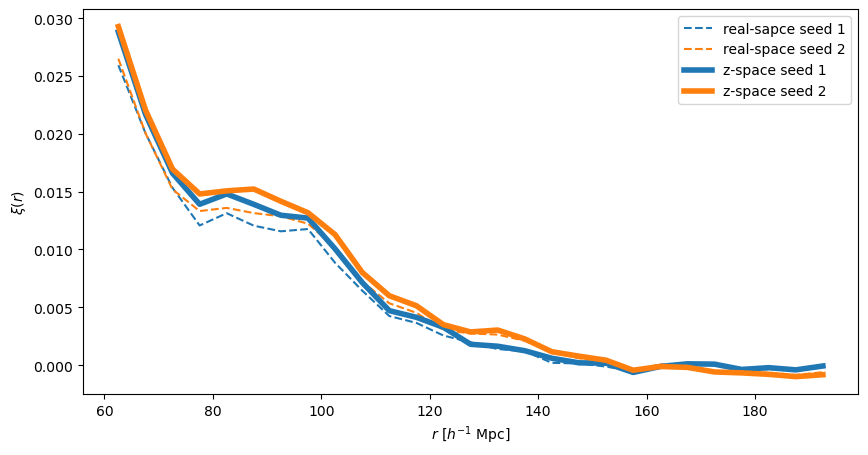

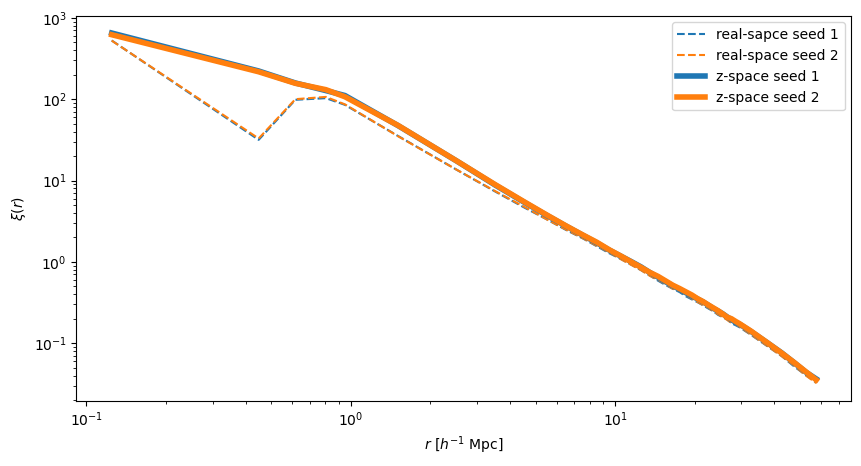

In [4]:
with h5py.File('./data/halo_corr.hdf5','r') as f:
    r = f['r'][:]
    xi_real = f['corr/real'][:]
    xi_zspace = f['corr/zspace'][:]
    xi_cen = f['corr/cen_zspace'][:]
    xi_sat = f['corr/sat_zspace'][:]
    ind_bins = [r > 60, r < 60]
with h5py.File('./data/halo_corr_seed123.hdf5','r') as f:
    r = f['r'][:]
    xi_real2 = f['corr/real'][:]
    xi_zspace2 = f['corr/zspace'][:]
    xi_cen2 = f['corr/cen_zspace'][:]
    xi_sat2 = f['corr/sat_zspace'][:]
    for ind in ind_bins:
        print(r[ind])
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))    
        ax.plot(r[ind], xi_real[ind], label='real-sapce seed 1', ls='--',color='C0')
        ax.plot(r[ind], xi_real2[ind], label='real-space seed 2', ls='--',color='C1')
        ax.plot(r[ind], xi_zspace[ind], label='z-space seed 1', color='C0', lw=4)
        ax.plot(r[ind], xi_zspace2[ind], label='z-space seed 2', color='C1', lw=4)
        ax.legend()
        ax.set_ylabel(r"$\xi(r)$")
        ax.set_xlabel(r"$r$ [$h^{-1} \ \mathrm{Mpc}$]")
    ax.set_xscale('log')
    ax.set_yscale('log')

total number of HOD galaxies =  176202
['Position', 'Selection', 'Value', 'Velocity', 'VelocityOffset', 'Weight', 'conc_NFWmodel', 'gal_type', 'halo_hostid', 'halo_id', 'halo_mvir', 'halo_num_centrals', 'halo_num_satellites', 'halo_rvir', 'halo_upid', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_x', 'halo_y', 'halo_z', 'host_centric_distance', 'vx', 'vy', 'vz', 'x', 'y', 'z']
number of centrals =  167407
number of satellites =  8795


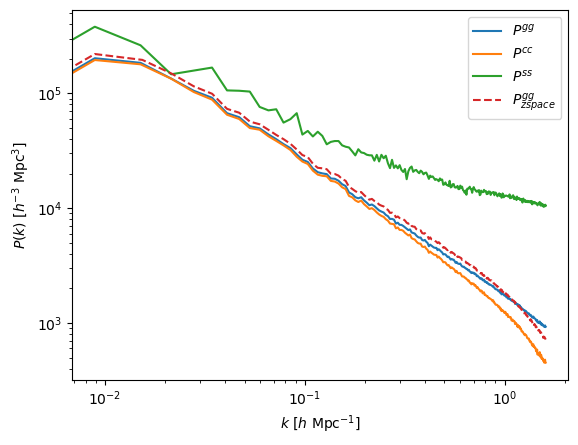

In [15]:
fig, ax= plt.subplots(1,1)
plot_power(fig, ax)

## Costum HOD model:

total number of HOD galaxies =  161937
['Position', 'Selection', 'Value', 'Velocity', 'VelocityOffset', 'Weight', 'conc_NFWmodel', 'gal_type', 'halo_hostid', 'halo_id', 'halo_mvir', 'halo_num_centrals', 'halo_num_satellites', 'halo_rvir', 'halo_upid', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_x', 'halo_y', 'halo_z', 'host_centric_distance', 'vx', 'vy', 'vz', 'x', 'y', 'z']
number of centrals =  158007
number of satellites =  3930
total number of HOD galaxies =  176202
['Position', 'Selection', 'Value', 'Velocity', 'VelocityOffset', 'Weight', 'conc_NFWmodel', 'gal_type', 'halo_hostid', 'halo_id', 'halo_mvir', 'halo_num_centrals', 'halo_num_satellites', 'halo_rvir', 'halo_upid', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_x', 'halo_y', 'halo_z', 'host_centric_distance', 'vx', 'vy', 'vz', 'x', 'y', 'z']
number of centrals =  167407
number of satellites =  8795


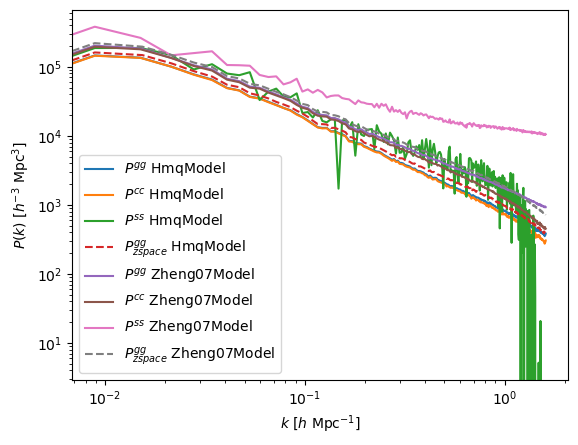

In [3]:
from nbodykit.hod import HmqModel
from nbodykit.hod import Zheng07Model
fig, ax= plt.subplots(1,1)
plot_power(fig, ax, hod_model=HmqModel)
plot_power(fig, ax, hod_model=Zheng07Model)

[2.00030003]
total number of HOD galaxies =  176970
['Position', 'Selection', 'Value', 'Velocity', 'VelocityOffset', 'Weight', 'conc_NFWmodel', 'gal_type', 'halo_hostid', 'halo_id', 'halo_mvir', 'halo_num_centrals', 'halo_num_satellites', 'halo_rvir', 'halo_upid', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_x', 'halo_y', 'halo_z', 'host_centric_distance', 'vx', 'vy', 'vz', 'x', 'y', 'z']
number of centrals =  158007
number of satellites =  18963


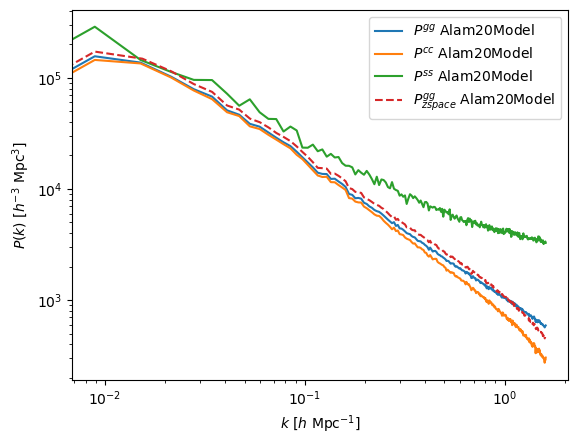

In [3]:
from halotools.empirical_models import PrebuiltHodModelFactory

Alam20Model = PrebuiltHodModelFactory('Alam20', redshift=2.00030003)
Alam20Model.__name__ = 'Alam20Model'
fig, ax= plt.subplots(1,1)
plot_power(fig, ax, hod_model=Alam20Model)

[2.00030003]


KeyError: 'Shear'

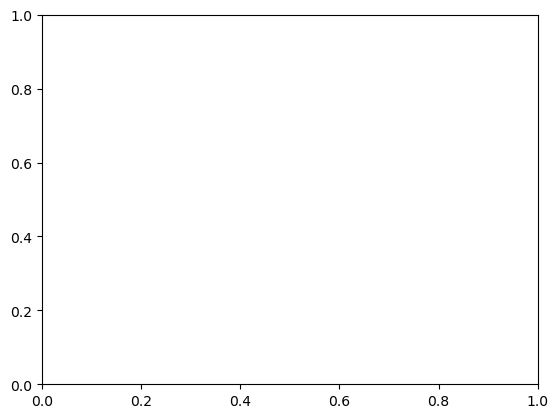

In [4]:
from halotools.empirical_models import PrebuiltHodModelFactory

Hadzhiyska23Model = PrebuiltHodModelFactory('hadzhiyska20', redshift=2.00030003)
Hadzhiyska23Model.__name__ = 'Hadzhiyska23Model'
fig, ax= plt.subplots(1,1)
plot_power(fig, ax, hod_model=Hadzhiyska23Model)

<KeysViewHDF5 ['corr', 'r']>
(67,) (26, 67)


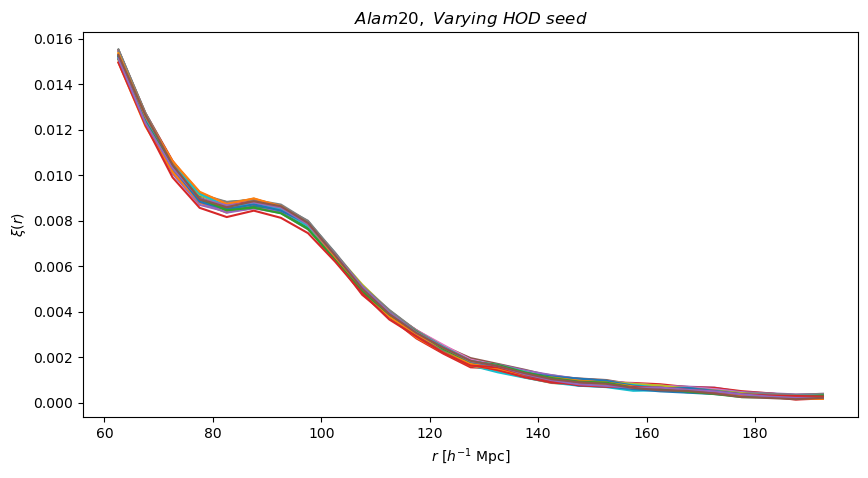

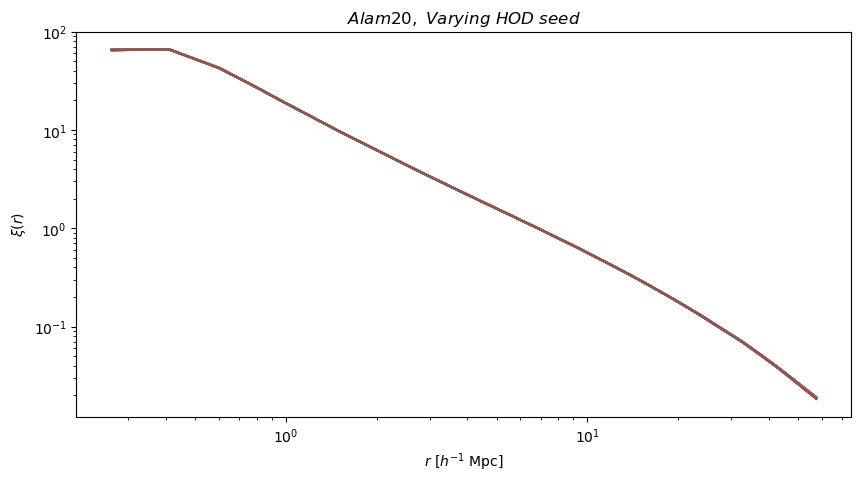

In [12]:
with h5py.File('./data/halo_corr_alam20.hdf5','r') as f:
    print(f.keys())
    r = f['r'][:]
    print(r.shape, f['corr/zspace'][:].shape)
    xi_real = f['corr/real'][:]
    xi_zspace = f['corr/zspace'][:]
    xi_cen = f['corr/cen_zspace'][:]
    xi_sat = f['corr/sat_zspace'][:]
    ind_bins = [r > 60, r < 60]
    for ind in ind_bins:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        for i in range(xi_zspace.shape[0]):
            #ax.plot(r[ind], xi_real[0,ind], label='halo real', ls='--',color='C0')
            ax.plot(r[ind], xi_zspace[i,ind])
            #ax.plot(r[ind], xi_cen[0,ind], label='cen zspace', color='C1')
            #ax.plot(r[ind], xi_sat[0,ind], label='sat zspace', color='C2')
        ax.set_ylabel(r"$\xi(r)$")
        ax.set_xlabel(r"$r$ [$h^{-1} \ \mathrm{Mpc}$]")
        ax.set_title(r'$Alam20, \ Varying \ HOD \ seed$')
    ax.set_xscale('log')
    ax.set_yscale('log')

(67,) (26, 67)


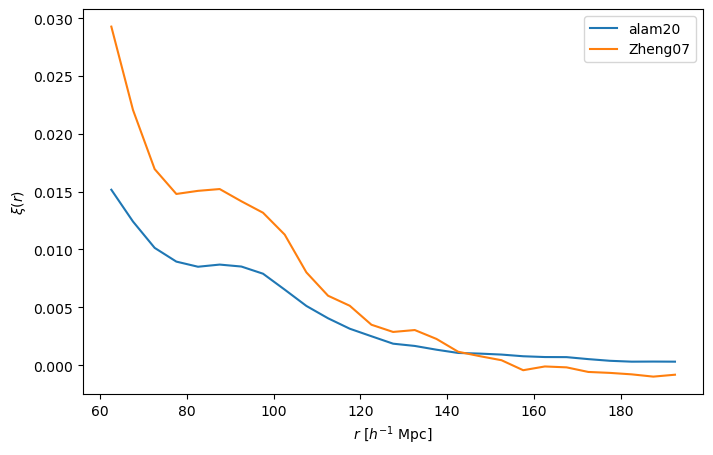

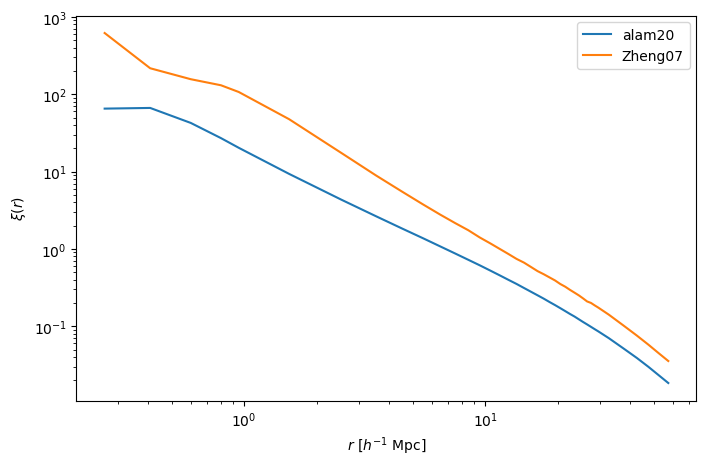

In [22]:
with h5py.File('./data/halo_corr_alam20.hdf5','r') as fa:
    with h5py.File('./data/halo_corr_seed123.hdf5','r') as fz:
        r = fa['r'][:]
        print(r.shape, fa['corr/zspace'][:].shape)
        ind_bins = [r > 60, r < 60]
        for ind in ind_bins:
            fig, ax = plt.subplots(1, 1, figsize=(8, 5))
            ax.plot(r[ind], fa['corr/zspace'][0,ind], label='alam20')
            ax.plot(r[ind], fz['corr/zspace'][ind], label='Zheng07')
            ax.set_ylabel(r"$\xi(r)$")
            ax.set_xlabel(r"$r$ [$h^{-1} \ \mathrm{Mpc}$]")
            ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')